# NMR Biomarker Test Cohort

Author: Olatomiwa Bifarin<br>
Department of Biochemistry and Molecular Biology<br>
University of Georgia<br>
Edison Lab<br>

Last edited: 06NOV2020 

_This is a static version of a Jupyter notebook, and work (documentation) is still in progress_ 

**Goals**: 
1. To merge NMR and MS Dataset. 

<a id="0"></a>

## Notebook Content

1.  [RCC Prediction in Model Cohort](#1)
2.  [RCC Prediction: Test Cohort](#2)
3.  [Chemical Information of Biomarkers](#3)


In [1]:
import dill
filepath = 'NMR_Biomarker_Test_Cohort.pkl'
dill.load_session('workspace/NMR_Biomarker_Test_Cohort.pkl') # Load the session

In [2]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
from matplotlib import style
import scipy
#For Seaborn plots
import seaborn as sns; sns.set(style='white')
#To ignore warning
import warnings
warnings.filterwarnings('ignore')

# More sharp and legible graphics
%config InlineBackend.figure_format = 'retina'

# Set seaborn figure labels to 'talk', to be more visible. 
sns.set_context('talk', font_scale=0.8)

# 1. RCC Prediction in Model Cohort
<a id="1"></a>

In [3]:
# Set seaborn figure labels to 'talk', to be more visible. 
sns.set_context('talk', font_scale=0.8)
import statsmodels as sms
from statsmodels.stats import multitest
from statistics import mean

# Machine Learning Libraries
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import roc_auc_score

from sklearn.neighbors import KNeighborsClassifier
from sklearn import svm

# Import Random Forest classifier, sklearn metrics
from sklearn.ensemble import RandomForestClassifier
from sklearn import metrics

# test train split and K-fold validation
from sklearn import model_selection
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold

from sklearn import decomposition

from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_selection import RFECV

In [5]:
import sklearn
import matplotlib
print('pandas', pd.__version__)
print('matplotlib', matplotlib.__version__)
print('Numpy', np.__version__)
print('Scipy', scipy.__version__)
print('Statsmodel', sms.__version__)
print('sklearn version', sklearn.__version__)

pandas 1.0.5
matplotlib 3.3.0
Numpy 1.19.1
Scipy 1.5.1
Statsmodel 0.11.1
sklearn version 0.23.2


#### Export Model Cohort Data

In [5]:
modelcohort = pd.read_excel('data/modelcohort.xlsx', index_col=0)

In [6]:
# select NMR features from the dataframe
NMR_modelcohort = modelcohort.iloc[:,7105:]
NMR_modelcohort.columns

Index(['Groups', 'unk1', 'unk2', 'bile_acid1', 'bile_acid2', 'HIVA', 'lactate',
       'unk3', 'acetate', 'acetone', 'unk4', 'acetoacetate', 'unk5',
       'pyruvate', 'citrate', 'DMA', 'unk6', 'methylguanidine', 'unk7',
       'choline', 'scylloinositol', 'taurine', 'acetoacetate_4HPA', 'glycine',
       'mannitol_1', 'mannitol_2', 'creatine', 'glycolate',
       'hippurate_hydroxyhippurate', 'Tatrate', 'unk8', 'unk9', 'fumarate',
       '4HPA', 'hippurate_2', 'hippurate_3', 'aminohippurate',
       'indoxylsulfate', 'hippurate_4', 'hypoxanthine_1', 'hypoxanthine_2',
       'formate', 'unk10', 'Trigonelline_1', 'Trigonellinamide_1',
       'Trigonellinamide_2', 'Trigonelline_2', 'Trigonellinamide_3', 'unk11'],
      dtype='object')

### a. Feature Selection 

### (i)  Select features with greater than 2-fold changes

In [7]:
#NMRMS = modelcohort.drop(['Sample ID', 'Patient ID', 'Collection', 'Gender',
#                         'Race', 'BMI', 'Smoker', 'Age'], axis=1)
Control = NMR_modelcohort[(NMR_modelcohort['Groups'] == 'Control')]
RCC = NMR_modelcohort[(NMR_modelcohort['Groups'] == 'RCC')]

dfmean = pd.DataFrame({'Features':NMR_modelcohort.drop(['Groups'], axis=1).mean(axis=0).index, 
                       'Control':Control.drop(['Groups'], axis=1).mean(axis=0).values,
                       'RCC':RCC.drop(['Groups'], axis=1).mean(axis=0).values})
dfmean.shape

(48, 3)

In [8]:
dfmean;

In [9]:
cols = []
ctr_val = dfmean['Control']
rcc_val = dfmean['RCC']

for ctr, rcc in zip(ctr_val, rcc_val):
    ratio1 = ctr/rcc
    ratio2 = rcc/ctr
    if ratio1 > 2:
        feature = dfmean[dfmean['Control']==ctr]['Features'].values.tolist()
        cols.append(feature)
    elif ratio2 > 2:
        feature = dfmean[dfmean['Control']==ctr]['Features'].values.tolist()
        cols.append(feature)
xfold_feat = [val for sublist in cols for val in sublist] # flatten out list of list.
len(xfold_feat)

2

In [10]:
print(' The following metabolites has > 2 fold change in NMR', xfold_feat)

 The following metabolites has > 2 fold change in NMR ['scylloinositol', 'aminohippurate']


### (ii) _t_-Test Feature Selection 

_T-Test Function_

In [11]:
def Ttest(metabolites, dfControl, dfTreat, alpha=0.05, var=True):
    '''
    Function conducts a T-test for the metabolites differences between two groups with 
    Benjamini-Hocberg FDR correction
    
    Inputs: 
    metabolites = A list containing names of metabolites
    dfControl = A pandas dataframe containing the control group metabolites data
    dfTreat =  A pandas dataframe containing the treatment group metabolites data
    alpha = alpha for statistical significant judgment, default 0.05
    var = If True (default), perform a standard independent 2 sample test that assumes 
    equal population variances [1]. If False, perform Welch’s t-test, which does not 
    assume equal population variance
    
    Outputs: A pandas dataframe with p-values of numerical cohort characteristics. 
    
    '''
    ttest_dict = {}
    for metabolite in metabolites:
        statistic, pvalue =  scipy.stats.ttest_ind(dfControl[metabolite], 
                                               dfTreat[metabolite], 
                                               equal_var=var)
        ttest_dict[metabolite] = pvalue 
        # a dictionary containing name of metabolites and p value after t-test
    ttest = pd.DataFrame.from_dict(ttest_dict, orient='index') # the dictionary in pandas df
    ttest_list=list(ttest_dict.values()) #values (pvalues) of ttest result in a list
    reject, pval_corrected, _, _ = sms.stats.multitest.multipletests(ttest_list, 
                                                                 alpha=alpha, 
                                                                 method='fdr_bh')
    ttest_results = pd.DataFrame({'Metabolite': metabolites, 'T-test p-value': ttest_list, 
                              'FDR p-value': pval_corrected, 'Reject H0': reject})
    Table = ttest_results.sort_values(by=['FDR p-value'])
    return Table

In [12]:
# '''List of final metabolites set'''
metabolite_list = NMR_modelcohort.drop(['Groups'], axis=1).columns

# '''List of final metabolites set'''
ttest_result = Ttest(metabolite_list, Control, RCC, alpha=0.05, var=True)

# '''List of Statistically relevant metabolites'''
# Select metabolites with <0.05 FDR
stat_sig = ttest_result.loc[ttest_result['Reject H0'] == True]

# Select metabolites with <0.05 t-test
#stat_sig = ttest_result.loc[ttest_result['T-test p-value'] <= 0.05]
print("The total number of significant metabolites/Features is: ", len(stat_sig))

The total number of significant metabolites/Features is:  12


In [13]:
stat_sig

,Metabolite,T-test p-value,FDR p-value,Reject H0
34,hippurate_3,0.000145,0.002616,True
19,scylloinositol,0.000218,0.002616,True
33,hippurate_2,0.000203,0.002616,True
44,Trigonellinamide_2,0.000218,0.002616,True
43,Trigonellinamide_1,0.000281,0.002693,True
35,aminohippurate,0.000372,0.002980,True
5,lactate,0.000494,0.003387,True
37,hippurate_4,0.000644,0.003864,True
27,hippurate_hydroxyhippurate,0.000801,0.004270,True
46,Trigonellinamide_3,0.001945,0.009335,True


In [14]:
Feature = stat_sig['Metabolite'].values.tolist(); # stat MS significant metabolites
MLfeatures = NMR_modelcohort[Feature] # p<0.05 metabolites
#MLfeatures =(MLfeatures - MLfeatures.mean(axis=0))/MLfeatures.std(axis=0) #autoscaling

In [15]:
MLfeatures.shape

(62, 12)

In [16]:
# Drop scylloinositol and aminohippurate, quantitation not accurate
MLfeatures = MLfeatures.drop(columns=['scylloinositol', 'aminohippurate'])

In [17]:
MLfeatures.astype(float);

In [18]:
correlated_features = set()
correlation_matrix = MLfeatures.astype(float).corr()

for i in range(len(correlation_matrix.columns)):
    for j in range(i):
        if abs(correlation_matrix.iloc[i, j]) > 0.7:
            colname = correlation_matrix.columns[i]
            correlated_features.add(colname)

In [19]:
MLfeatures = MLfeatures.drop(correlated_features, axis=1)
MLfeatures.shape

(62, 4)

In [20]:
MLfeatures.columns

Index(['hippurate_3', 'Trigonellinamide_2', 'lactate', 'mannitol_1'], dtype='object')

In [21]:
MLfeatures = NMR_modelcohort.filter(['hippurate_2', 'Trigonellinamide_1',
                                     'lactate','mannitol_1'])
biomarker = MLfeatures

In [22]:
# replace hippurate_3 by hippurate_2 (7.567 7.524) more accurate
biomarker.columns

Index(['hippurate_2', 'Trigonellinamide_1', 'lactate', 'mannitol_1'], dtype='object')

### c. Machine Learning for RCC Prediction

_Machine Learning Model Function_

In [23]:
def ml_model(X, y, model, kfold=5):
    
    '''
    FUNCTION: 
    A  machine learning function under Kfold cross validation conditions  
    
    DEPENDENCY: 
    Various Sklearn packages
    from sklearn import metrics
    from sklearn.model_selection import train_test_split
    from sklearn.model_selection import KFold
    from sklearn.metrics import roc_curve, auc
    from sklearn.metrics import roc_auc_score
    
    INPUTS: 
    X = numpy.ndaarray: features
    y = numpy.ndaarray: Labels encoded as 0s and 1s. 
    model = machine learning model
    kfold = numeric. K-fold default is 5. 
    
    OUTPUT: 
    A list containing the following machine learning metrics: 
    Area Under the Curve(AUC), Accuracy (ACC), Precision (PRE), 
    Recall (REC), F1-core (FS), Matthew's Correlation Coefficient (MCC). 
    
    '''

    
    cv = model_selection.StratifiedKFold(n_splits=kfold, random_state=42, shuffle=True)
    # define 'list' of various metrics
    AUC, ACC, PRE, REC, FS, MCC, SPE = [], [], [], [], [], [], [] 
    performance = []
    
    for (train, test), i in zip(cv.split(X, y), range(kfold)):
        # training the model
        model.fit(X[train], y[train])
        y_pred = model.predict(X[test])
        
        #Retrieving metrics after testing
        modelprobs = model.predict_proba(X[test])
        fpr, tpr, thresholds = metrics.roc_curve(y[test], modelprobs[:,1])
        roc_auc = auc(fpr, tpr)
        accuracy = metrics.accuracy_score(y[test], y_pred)
        precision = metrics.precision_score(y[test], y_pred)
        recall = metrics.recall_score(y[test], y_pred)
        f1_score = metrics.f1_score(y[test], y_pred)
        mcc = metrics.matthews_corrcoef(y[test], y_pred)
        # coding specificity
        tn, fp, fn, tp = confusion_matrix(y[test], y_pred).ravel()
        specificity = tn / (tn+fp)
        # append metrics to list
        AUC.append(roc_auc)
        ACC.append(accuracy)
        PRE.append(precision)
        REC.append(recall)
        FS.append(f1_score)
        MCC.append(mcc)
        SPE.append(specificity)
        
    return AUC, ACC, PRE, REC, FS, MCC, SPE

_Machine Learning Metric Plot Function_

In [24]:
def MLmetric_plot(data_dict, y_label):
    '''
    FUNCTION: 
    To plot machine learning metrics from ml_model function.   
    
    DEPENDENCY: 
    Pandas, seaborn, 
    
    INPUTS: 
    data_dict = dictionary. Contains ML model name and metric scores
    y_label = String. Label for the y-axis 
    
    OUTPUT: 
    Figure
    
    '''
    
    fig = pd.DataFrame(data=data_dict)
    splot = sns.barplot(x='Model', y=y_label, data=fig);
    #splot = sns.swarmplot(data=ACCfig, orient='h', s=10, alpha=0.7, color=".25");
    for p in splot.patches:
        splot.annotate(format(p.get_height(), '.2f'), 
                              (p.get_x() + p.get_width() / 2., p.get_height()), 
                              ha = 'center', va = 'center', xytext = (6, 15), 
                              textcoords = 'offset points')
    return splot
#plt.savefig('testACC.svg', dpi=300)



### Train Machine Learning Models.

# 2. RCC Prediction: Test Cohort
<a id="2"></a>

In [25]:
testcohort = pd.read_excel('data/testcohort.xlsx', index_col=0)

In [26]:
NMR_testcohort = testcohort.iloc[:,7105:]
NMR_testcohort.columns

Index(['Groups', 'unk1', 'unk2', 'bile_acid1', 'bile_acid2', 'HIVA', 'lactate',
       'unk3', 'acetate', 'acetone', 'unk4', 'acetoacetate', 'unk5',
       'pyruvate', 'citrate', 'DMA', 'unk6', 'methylguanidine', 'unk7',
       'choline', 'scylloinositol', 'taurine', 'acetoacetate_4HPA', 'glycine',
       'mannitol_1', 'mannitol_2', 'creatine', 'glycolate',
       'hippurate_hydroxyhippurate', 'Tatrate', 'unk8', 'unk9', 'fumarate',
       '4HPA', 'hippurate_2', 'hippurate_3', 'aminohippurate',
       'indoxylsulfate', 'hippurate_4', 'hypoxanthine_1', 'hypoxanthine_2',
       'formate', 'unk10', 'Trigonelline_1', 'Trigonellinamide_1',
       'Trigonellinamide_2', 'Trigonelline_2', 'Trigonellinamide_3', 'unk11',
       '_merge'],
      dtype='object')

In [27]:
MLfeatures2 = testcohort[biomarker.columns]
MLfeatures2_scaled =(MLfeatures2 - MLfeatures2.mean(axis=0))/MLfeatures2.std(axis=0) #autoscaling
MLfeatures2.shape

(194, 4)

Define features and labels.

In [28]:
dfgrp = testcohort.filter(['Groups'], axis=1)
#convert strings (RCC, Control) to integers
dfgroup = dfgrp['Groups'].map({'Control': 0, 'RCC': 1}) 
X = MLfeatures2_scaled.values
y = dfgroup.values
print (X.shape)
print (y.shape)

(194, 4)
(194,)


Model saved in workspace

from sklearn.metrics import confusion_matrix
##### Random Forest
RF=RandomForestClassifier(n_estimators=50, min_samples_split=2, 
                          min_samples_leaf=3, max_features='auto', max_depth=10, 
                          bootstrap=True, random_state=42)
metric = ml_model(X, y, RF)
RF_AUC, RF_ACC, RF_PRE, RF_REC, RF_FS, RF_MCC, RF_SPE = metric[0], metric[1], metric[2], metric[3], metric[4], metric[5], metric[6]


##### Linear-SVM
linsvm = svm.SVC(C = 1, kernel = 'linear', probability=True, random_state=42)
metric = ml_model(X, y, linsvm)
linsvm_AUC, linsvm_ACC, linsvm_PRE, linsvm_REC, linsvm_FS, linsvm_MCC, linsvm_SPE = metric[0], metric[1], metric[2], metric[3], metric[4], metric[5], metric[6]


##### SVM
#clf = svm.SVC(kernel='linear', probability=True)
clf = svm.SVC(C = 10, gamma = 0.3, kernel = 'rbf', probability=True, random_state=42)
metric = ml_model(X, y, clf)
clf_AUC, clf_ACC, clf_PRE, clf_REC, clf_FS, clf_MCC, clf_SPE = metric[0], metric[1], metric[2], metric[3], metric[4], metric[5], metric[6]

##### KNN
knn = KNeighborsClassifier(n_neighbors=5, p=1)
metric = ml_model(X, y, knn)
KNN_AUC, KNN_ACC, KNN_PRE, KNN_REC, KNN_FS, KNN_MCC, KNN_SPE = metric[0], metric[1], metric[2], metric[3], metric[4], metric[5], metric[6]


### Call the tuned machine learning algorithms

In [29]:
print(RF)
print(linsvm)
print(clf)
print(knn)

RandomForestClassifier(max_depth=10, min_samples_leaf=3, n_estimators=50,
                       random_state=42)
SVC(C=1, kernel='linear', probability=True, random_state=42)
SVC(C=10, gamma=0.3, probability=True, random_state=42)
KNeighborsClassifier(p=1)


**AUC**

In [30]:
sns.set_context('talk', font_scale=0.8)

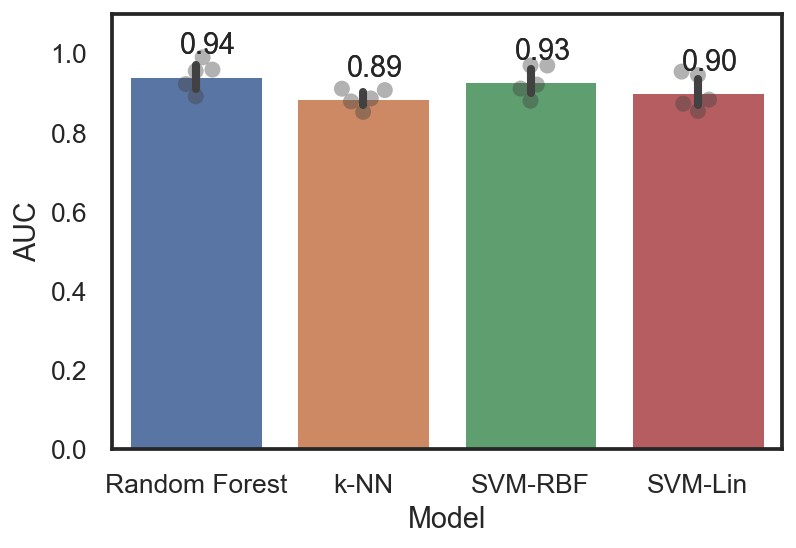

In [31]:
AUCfig = {'Model': ['Random Forest', 'k-NN', 'SVM-RBF', 'SVM-Lin'], 
               'AUC':[mean(RF_AUC), mean(KNN_AUC), mean(clf_AUC), mean(linsvm_AUC)]}

afig = {'RF': RF_AUC, 'KNN': KNN_AUC, 'SVM': clf_AUC, 'Lin-SVM': linsvm_AUC}
bafig = pd.DataFrame(afig)
sns.barplot(data=bafig)
sns.swarmplot(data=bafig,s=8, alpha=0.4, color=".25")
plt.ylim(0,1.1)

MLmetric_plot(AUCfig, 'AUC');
#plt.title('ML Model AUC Comparison for RCC prediction');
#plt.savefig('AUC_NMRtest.svg', dpi=300)

In [32]:
# A function to print out all numeric (and summary of) results
def summary(name, result):
    print ('All Test result for', name, result)
    print ('Summary metric for', name, round(mean(result),2),'+/-', round(np.std(result),2))

In [33]:
summary('Random Forest', RF_AUC)
summary('k-NN', KNN_AUC)
summary('RBF SVM', clf_AUC)
summary('Linear SVM', linsvm_AUC)

All Test result for Random Forest [0.922077922077922, 0.9551724137931034, 0.9896551724137931, 0.9586206896551723, 0.8910714285714287]
Summary metric for Random Forest 0.94 +/- 0.03
All Test result for k-NN [0.8782467532467533, 0.9103448275862069, 0.9068965517241379, 0.8517241379310345, 0.8857142857142857]
Summary metric for k-NN 0.89 +/- 0.02
All Test result for RBF SVM [0.8798701298701299, 0.9689655172413792, 0.9689655172413794, 0.9206896551724137, 0.9107142857142858]
Summary metric for RBF SVM 0.93 +/- 0.03
All Test result for Linear SVM [0.8538961038961039, 0.8827586206896553, 0.8724137931034482, 0.9448275862068966, 0.9535714285714285]
Summary metric for Linear SVM 0.9 +/- 0.04


**Accuracy**

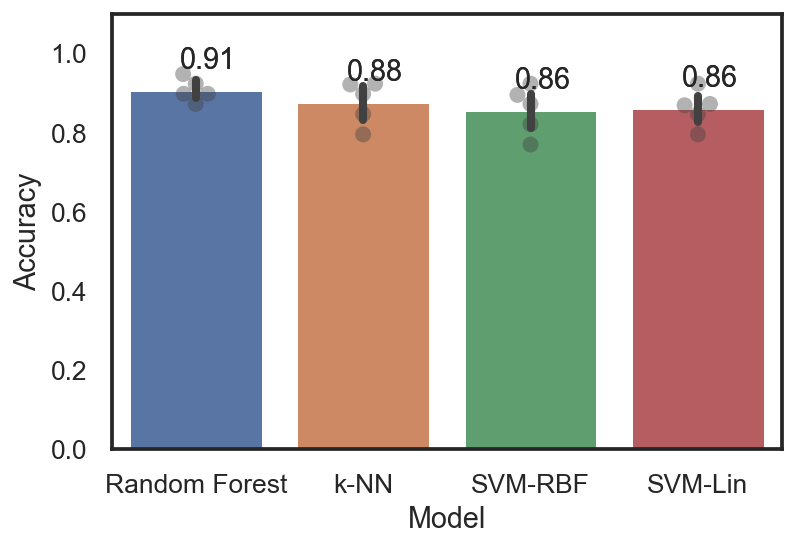

In [34]:
ACC_fig = {'Model': ['Random Forest', 'k-NN', 'SVM-RBF', 'SVM-Lin'], 
               'Accuracy':[mean(RF_ACC), mean(KNN_ACC), mean(clf_ACC), mean(linsvm_ACC)]}

afig = {'RF': RF_ACC, 'KNN': KNN_ACC, 'SVM': clf_ACC, 'Lin-SVM': linsvm_ACC}
bafig = pd.DataFrame(afig)
sns.barplot(data=bafig)
sns.swarmplot(data=bafig,s=8, alpha=0.4, color=".25")
plt.ylim(0,1.1)

MLmetric_plot(ACC_fig, 'Accuracy');
#plt.title('ML Model Accuracy Comparison for RCC prediction');
#plt.savefig('ACC_NMRtest.svg', dpi=300)

In [35]:
summary('Random Forest', RF_ACC)
summary('k-NN', KNN_ACC)
summary('RBF SVM', clf_ACC)
summary('Linear SVM', linsvm_ACC)

All Test result for Random Forest [0.8717948717948718, 0.8974358974358975, 0.9230769230769231, 0.8974358974358975, 0.9473684210526315]
Summary metric for Random Forest 0.91 +/- 0.03
All Test result for k-NN [0.7948717948717948, 0.8974358974358975, 0.9230769230769231, 0.8461538461538461, 0.9210526315789473]
Summary metric for k-NN 0.88 +/- 0.05
All Test result for RBF SVM [0.7692307692307693, 0.8717948717948718, 0.9230769230769231, 0.8205128205128205, 0.8947368421052632]
Summary metric for RBF SVM 0.86 +/- 0.05
All Test result for Linear SVM [0.7948717948717948, 0.9230769230769231, 0.8717948717948718, 0.8461538461538461, 0.868421052631579]
Summary metric for Linear SVM 0.86 +/- 0.04


**Precision**

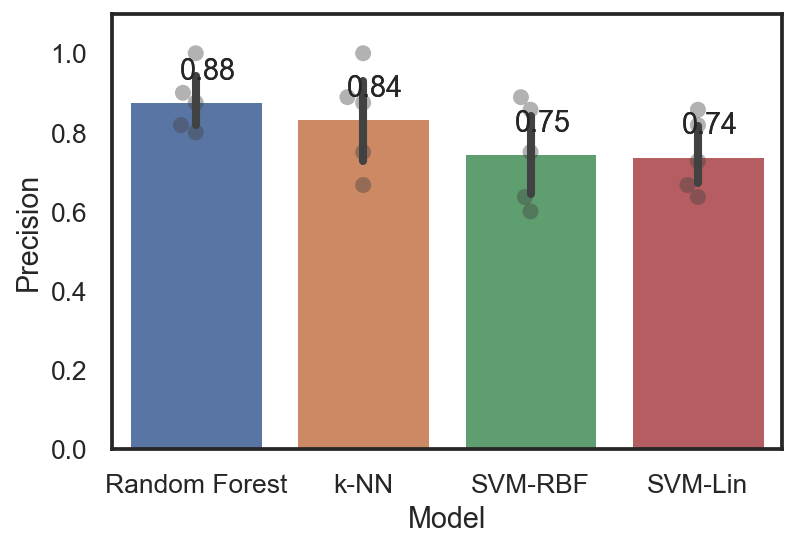

In [36]:
PREfig = {'Model': ['Random Forest', 'k-NN', 'SVM-RBF', 'SVM-Lin'], 
               'Precision':[mean(RF_PRE), mean(KNN_PRE), mean(clf_PRE), mean(linsvm_PRE)]}

afig = {'RF': RF_PRE, 'KNN': KNN_PRE, 'SVM': clf_PRE, 'Lin-SVM': linsvm_PRE}
bafig = pd.DataFrame(afig)
sns.barplot(data=bafig)
sns.swarmplot(data=bafig,s=8, alpha=0.4, color=".25")
plt.ylim(0,1.1)

MLmetric_plot(PREfig, 'Precision');
#plt.title('ML Model Precision Comparison for RCC prediction');
#plt.savefig('PRE_NMRtest.svg', dpi=300)

**Recall**

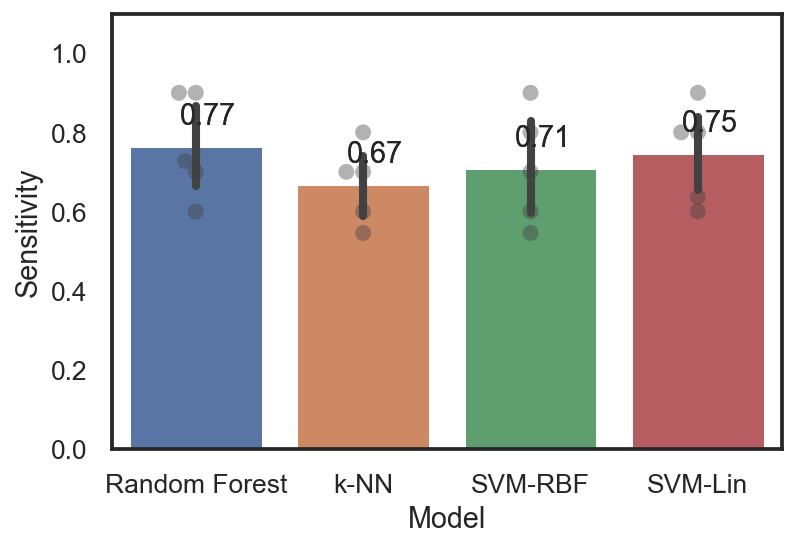

In [37]:
RECfig = {'Model': ['Random Forest', 'k-NN', 'SVM-RBF', 'SVM-Lin'], 
               'Sensitivity':[mean(RF_REC), mean(KNN_REC), mean(clf_REC), mean(linsvm_REC)]}

afig = {'RF': RF_REC, 'KNN': KNN_REC, 'SVM': clf_REC, 'Lin-SVM': linsvm_REC}
bafig = pd.DataFrame(afig)
sns.barplot(data=bafig)
sns.swarmplot(data=bafig,s=8, alpha=0.4, color=".25")
plt.ylim(0,1.1)

MLmetric_plot(RECfig, 'Sensitivity');
#plt.title('ML Model Recall Comparison for RCC prediction');
#plt.savefig('SEN_NMRtest.svg', dpi=300)

In [38]:
summary('Random Forest', RF_REC)
summary('k-NN', KNN_REC)
summary('RBF SVM', clf_REC)
summary('Linear SVM', linsvm_REC)

All Test result for Random Forest [0.7272727272727273, 0.6, 0.9, 0.7, 0.9]
Summary metric for Random Forest 0.77 +/- 0.12
All Test result for k-NN [0.5454545454545454, 0.7, 0.8, 0.6, 0.7]
Summary metric for k-NN 0.67 +/- 0.09
All Test result for RBF SVM [0.5454545454545454, 0.6, 0.8, 0.7, 0.9]
Summary metric for RBF SVM 0.71 +/- 0.13
All Test result for Linear SVM [0.6363636363636364, 0.9, 0.6, 0.8, 0.8]
Summary metric for Linear SVM 0.75 +/- 0.11


**F1 Score**

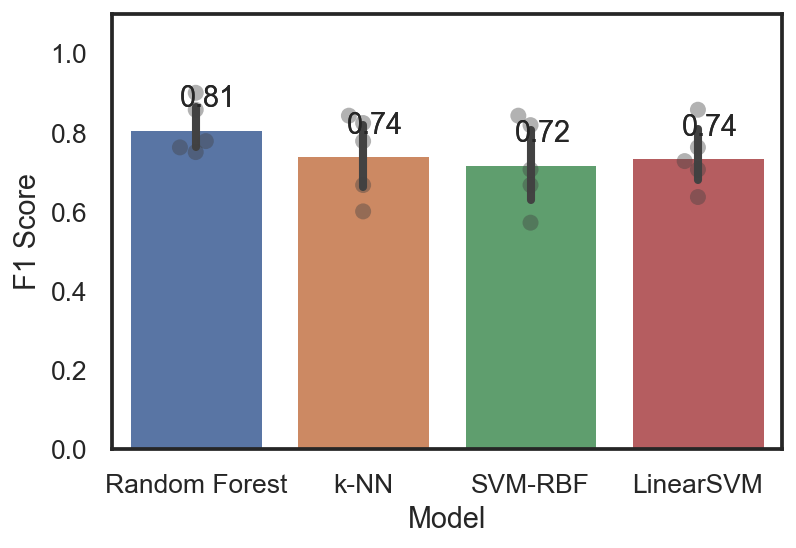

In [39]:
RECfig = {'Model': ['Random Forest', 'k-NN', 'SVM-RBF', 'LinearSVM'], 
               'F1 Score':[mean(RF_FS), mean(KNN_FS), mean(clf_FS), mean(linsvm_FS)]}

afig = {'RF': RF_FS, 'KNN': KNN_FS, 'SVM': clf_FS, 'Lin-SVM': linsvm_FS}
bafig = pd.DataFrame(afig)
sns.barplot(data=bafig)
sns.swarmplot(data=bafig,s=8, alpha=0.4, color=".25")
plt.ylim(0,1.1)

MLmetric_plot(RECfig, 'F1 Score');
#plt.title('ML Model F1 Score Comparison for RCC prediction');
#plt.savefig('F1_NMRtest.svg', dpi=300)

**Specificity**

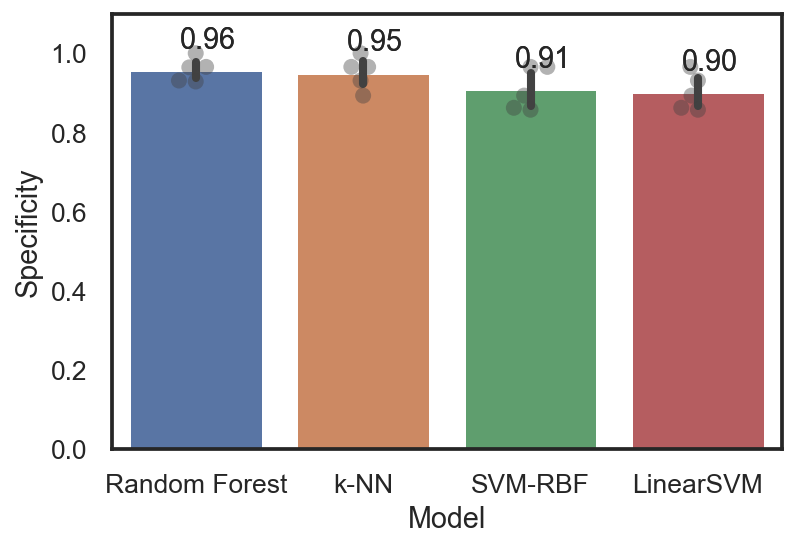

In [40]:
SPEfig = {'Model': ['Random Forest', 'k-NN', 'SVM-RBF', 'LinearSVM'], 
               'Specificity':[mean(RF_SPE), mean(KNN_SPE), mean(clf_SPE), mean(linsvm_SPE)]}

afig = {'RF': RF_SPE, 'KNN': KNN_SPE, 'SVM': clf_SPE, 'Lin-SVM': linsvm_SPE}
bafig = pd.DataFrame(afig)
sns.barplot(data=bafig)
sns.swarmplot(data=bafig,s=8, alpha=0.4, color=".25")
plt.ylim(0,1.1)

MLmetric_plot(SPEfig, 'Specificity');
#plt.title('ML Model F1 Score Comparison for RCC prediction');
#plt.savefig('SPE_NMRtest.svg', dpi=300)

In [41]:
summary('Random Forest', RF_SPE)
summary('k-NN', KNN_SPE)
summary('RBF SVM', clf_SPE)
summary('Linear SVM', linsvm_SPE)

All Test result for Random Forest [0.9285714285714286, 1.0, 0.9310344827586207, 0.9655172413793104, 0.9642857142857143]
Summary metric for Random Forest 0.96 +/- 0.03
All Test result for k-NN [0.8928571428571429, 0.9655172413793104, 0.9655172413793104, 0.9310344827586207, 1.0]
Summary metric for k-NN 0.95 +/- 0.04
All Test result for RBF SVM [0.8571428571428571, 0.9655172413793104, 0.9655172413793104, 0.8620689655172413, 0.8928571428571429]
Summary metric for RBF SVM 0.91 +/- 0.05
All Test result for Linear SVM [0.8571428571428571, 0.9310344827586207, 0.9655172413793104, 0.8620689655172413, 0.8928571428571429]
Summary metric for Linear SVM 0.9 +/- 0.04


The best classifier is RF, and here are the feature importance from random forest:

In [42]:
feature_imp = pd.Series(RF.feature_importances_,
                        index=MLfeatures2.columns).sort_values(ascending=False)

No handles with labels found to put in legend.


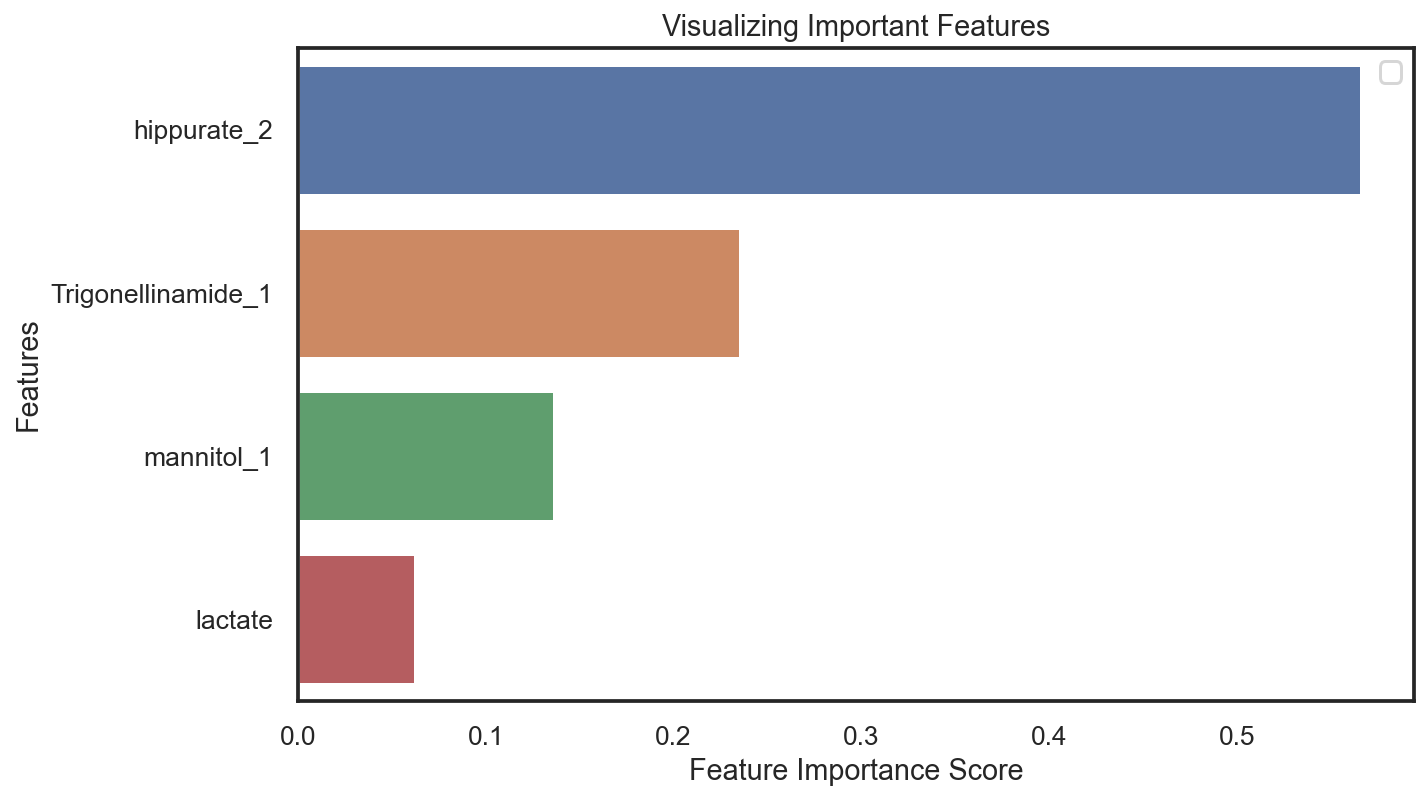

In [43]:
plt.figure(figsize=(10,6))
sns.barplot(x=feature_imp, y=feature_imp.index)
# Add labels to your graph
plt.xlabel('Feature Importance Score')
plt.ylabel('Features')
plt.title("Visualizing Important Features")
plt.legend()
#plt.savefig('RF_Features.svg', dpi=300)
plt.show()

### Biomarkers: PCA, Hierarchical clustering and Boxplot Visualization

In [44]:
print (testcohort.shape)
print (MLfeatures2.shape)

(194, 7155)
(194, 4)


In [45]:
group_loc = testcohort.columns.get_loc("Groups") #autoscaling
biomarker2 =  testcohort.iloc[:, group_loc].to_frame().join(MLfeatures2)
biomarker2.shape

(194, 5)

**_T_-test for metabolic features in the test cohort**

In [46]:
# Select the metabolic feature panel for RCC
MLfeatures2 = NMR_testcohort[biomarker2.iloc[:, 1:].columns]
# Get the 'group' location
group_loc = NMR_testcohort.columns.get_loc("Groups") 
# Join group with the metabolic feature panel for RCC
biomarker_TC =  NMR_testcohort.iloc[:, group_loc].to_frame().join(MLfeatures2)
# Build biomarker dataframe for Controls and RCC
Control_TC = biomarker_TC[(biomarker_TC['Groups'] == 'Control')]
RCC_TC = biomarker_TC[(biomarker_TC['Groups'] == 'RCC')]
# drop groups from the biomarker_TC columns
biomarker_TC.drop(['Groups'], axis=1, inplace=True)

In [47]:
# Select the metabolic feature panel for RCC
MLfeatures2 = testcohort[biomarker.columns]
# Get the 'group' location
group_loc = testcohort.columns.get_loc("Groups") 
# Join group with the metabolic feature panel for RCC
biomarker_TC =  testcohort.iloc[:, group_loc].to_frame().join(MLfeatures2)
# Build biomarker dataframe for Controls and RCC
Control_TC = biomarker_TC[(biomarker_TC['Groups'] == 'Control')]
RCC_TC = biomarker_TC[(biomarker_TC['Groups'] == 'RCC')]
# drop groups from the biomarker_TC columns
biomarker_TC.drop(['Groups'], axis=1, inplace=True)

In [48]:
ttest_result2 = Ttest(biomarker_TC.columns, Control_TC, 
                      RCC_TC, alpha=0.05, var=False)
ttest_result2

,Metabolite,T-test p-value,FDR p-value,Reject H0
0,hippurate_2,1.438252e-13,3.064589e-13,True
1,Trigonellinamide_1,1.532294e-13,3.064589e-13,True
2,lactate,1.114930e-01,1.114930e-01,False
3,mannitol_1,9.147779e-02,1.114930e-01,False


Boxplot

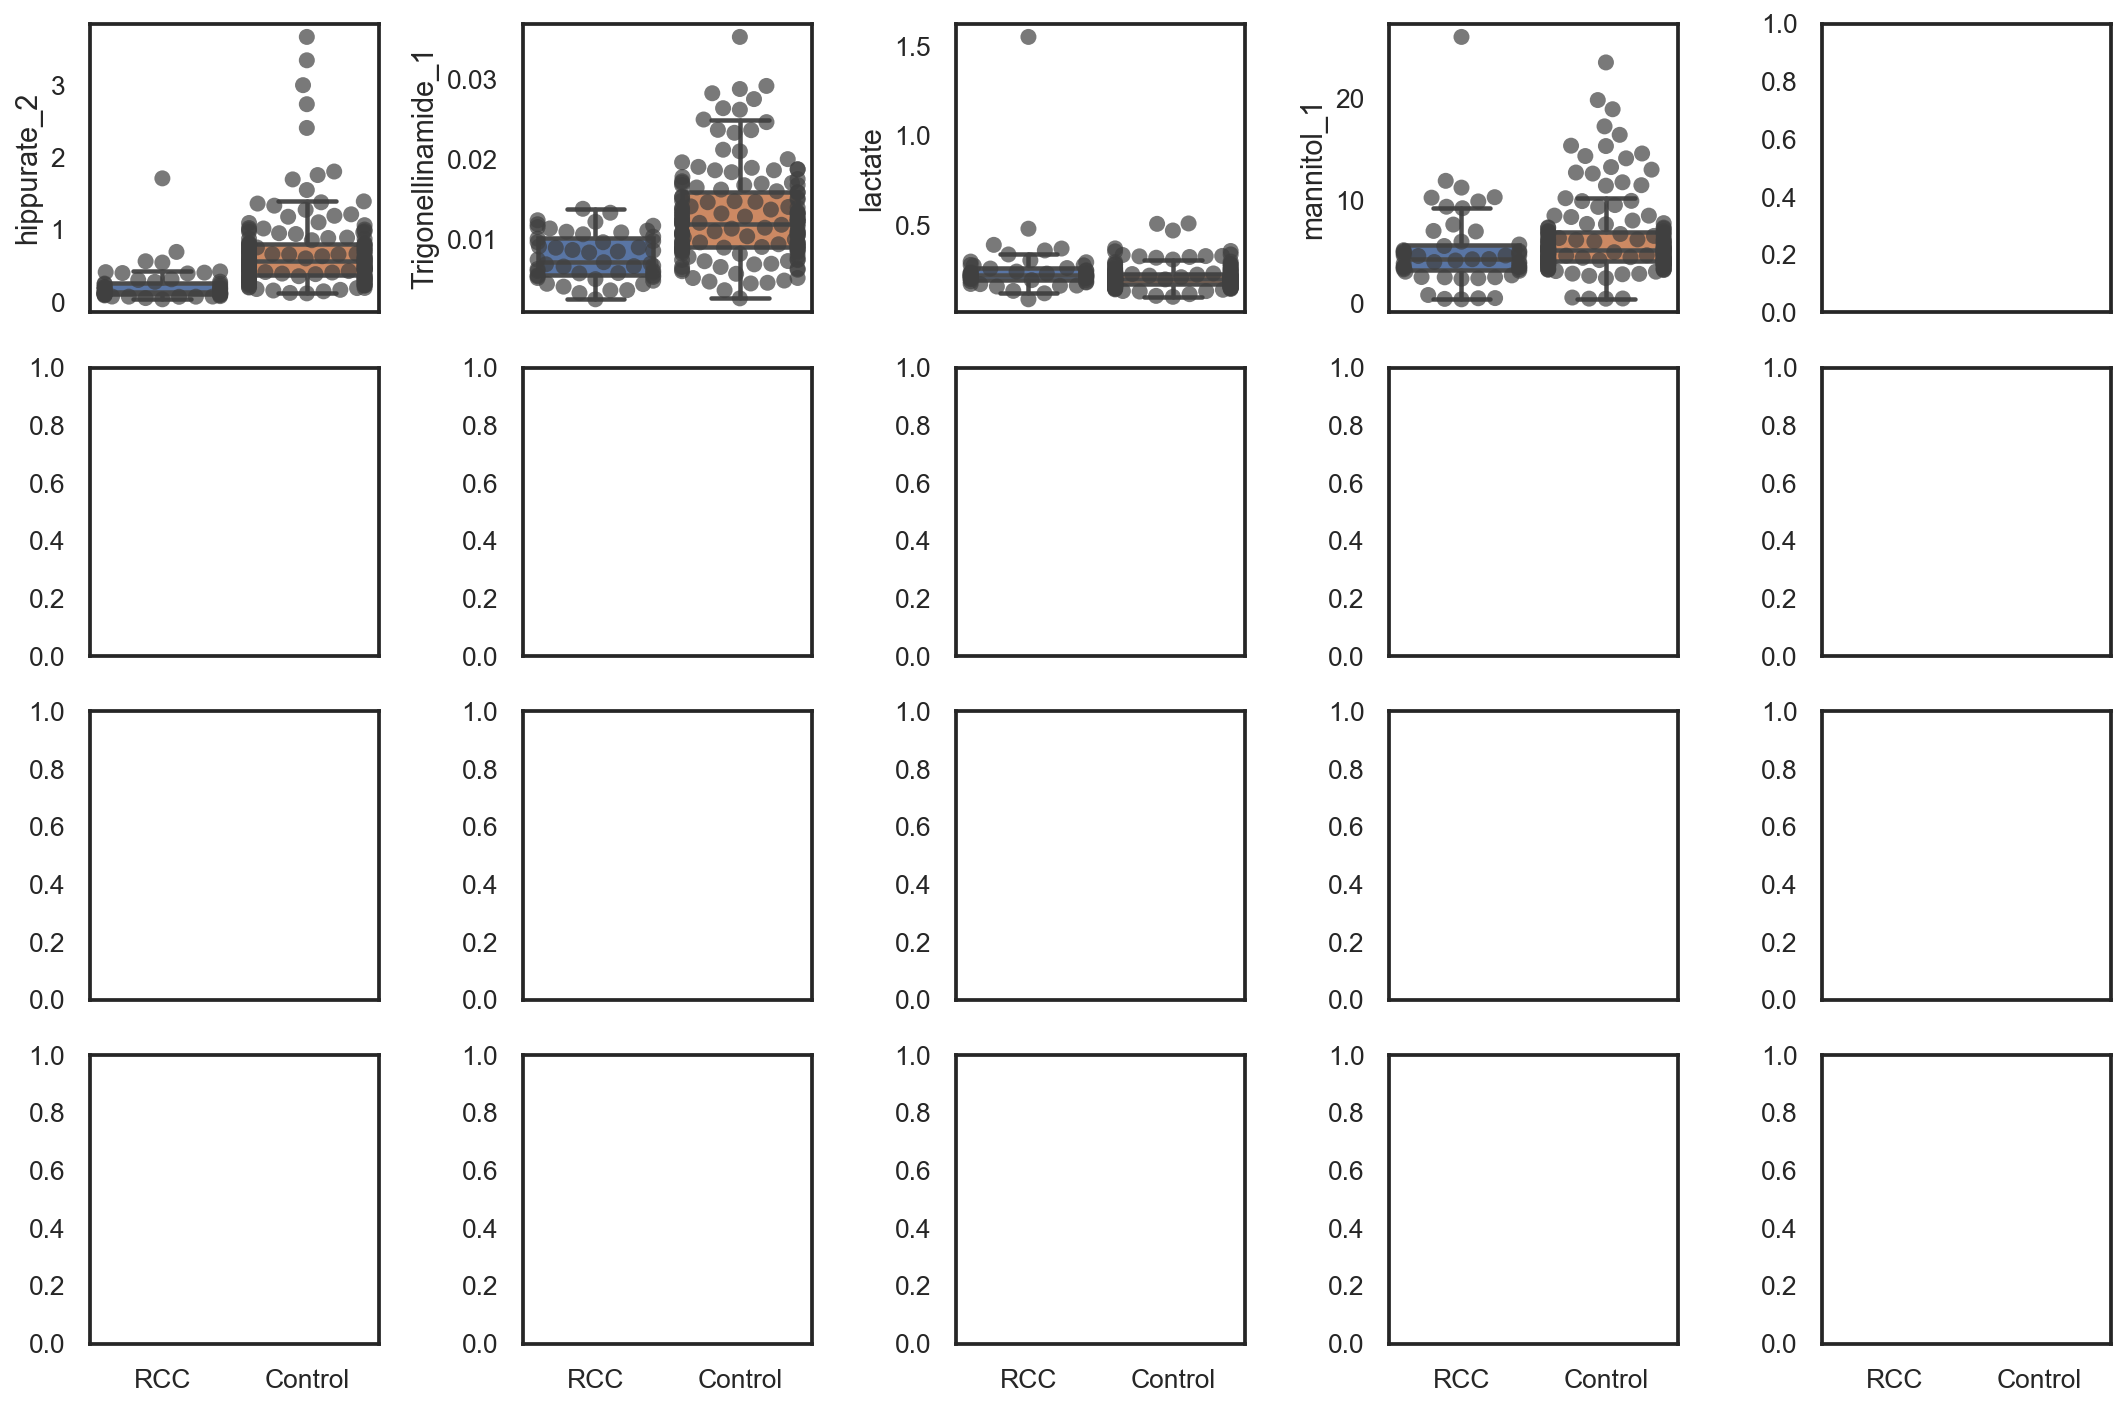

In [49]:
# Select the metabolic feature panel for RCC
MLfeatures2 = NMR_testcohort[biomarker2.iloc[:, 1:].columns]
# Get the 'group' location
group_loc = NMR_testcohort.columns.get_loc("Groups") 
# Join group with the metabolic feature panel for RCC
biomarker_TC =  NMR_testcohort.iloc[:, group_loc].to_frame().join(MLfeatures2)


# Metabolites Quantification via boxplot or barplot
fig, axes = plt.subplots(nrows=4, ncols=5, sharex=True, figsize=(15, 10))
for idx, feat in enumerate(biomarker_TC.columns[1:]):
    ax = axes[int(idx / 5), idx % 5]
    sns.boxplot(x='Groups', y=feat, data=biomarker_TC, ax=ax, showfliers=False)
    #sns.barplot (x='Groups', y=feat, data=df, ax=ax, capsize=.06)
    sns.swarmplot(x='Groups', y=feat, data=biomarker2, 
                  ax=ax, s=8, alpha=0.7, color=".25");
    ax.set_xlabel('')
    ax.set_ylabel(feat) #feat
fig.tight_layout();
#plt.savefig('RQ_NMRtest.svg', dpi=300)

**PCA**

In [50]:
def PCA_Python(X, y, scaled=True):
    '''
    FUNCTION:  
    A principle component analysis function
    Note that number of component to be picked is fixed at 2 and scaling is pareto. 
    **Edit function to make this flexible** 
    
    DEPENDENCY: sklearn
    from sklearn import decomposition
    
    INPUT: Pandas dataframe
    X: Data. Numerical.
    y: Groups
    scaled: Boolean. Default=True
   
    
    OUTPUT: figure
    A PCA score plot
    
    '''
    pca = decomposition.PCA(n_components=2)
    if scaled == True: 
        X_centered = (X - X.mean(axis=0))/np.sqrt(X.std(axis=0)) # pareto scaling.
        #X_centered =(X - X.mean(axis=0))/X.std(axis=0) #autoscaling
    elif scaled == False:
        X_centered = X
    
    pca.fit(X_centered)
    X_pca = pca.transform(X_centered)
    Var = pca.explained_variance_ratio_ # returns variance ratio of the selected component. 
    a = plt.plot(X_pca[y == 0, 0], X_pca[y == 0, 1], 'bo', label='Control');
    b = plt.plot(X_pca[y == 1, 0], X_pca[y == 1, 1], 'ro', label='RCC');
    c = plt.xlabel("PC1: " + str(round(Var[0]*100, 2)) + "%");
    d = plt.ylabel("PC2: " + str(round(Var[1]*100, 2))+ "%");
    e = plt.legend(loc=0);
    return (a, b, c, d, e)

**PCA score plots using all ML features**

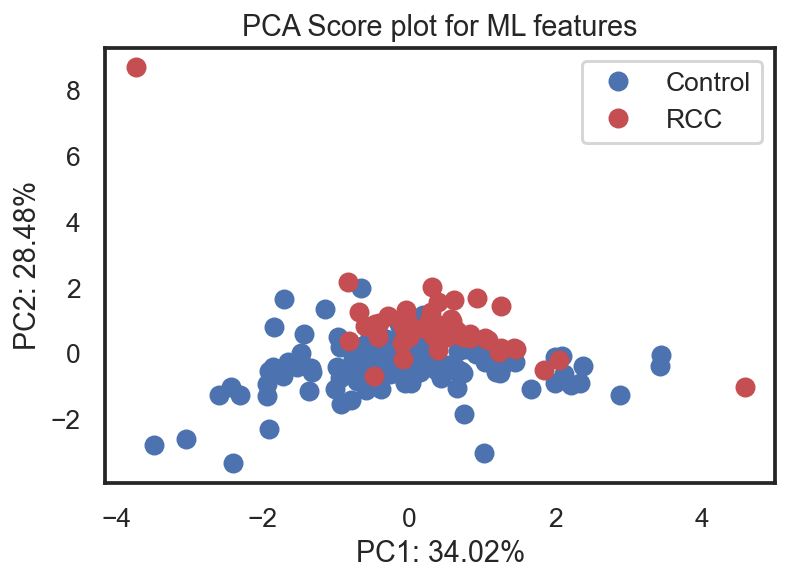

In [51]:
ylabel = biomarker2['Groups'].map({'Control' : 0, 'RCC' : 1})
PCA_Python(MLfeatures2_scaled, ylabel, False)
plt.title('PCA Score plot for ML features');

**Hierarchial Clustering using all ML features**

In [52]:
group_loc = testcohort.columns.get_loc("Groups") #autoscaling
biomarker2 =  testcohort.iloc[:, group_loc].to_frame().join(MLfeatures2)
biomarker2.shape

(194, 5)

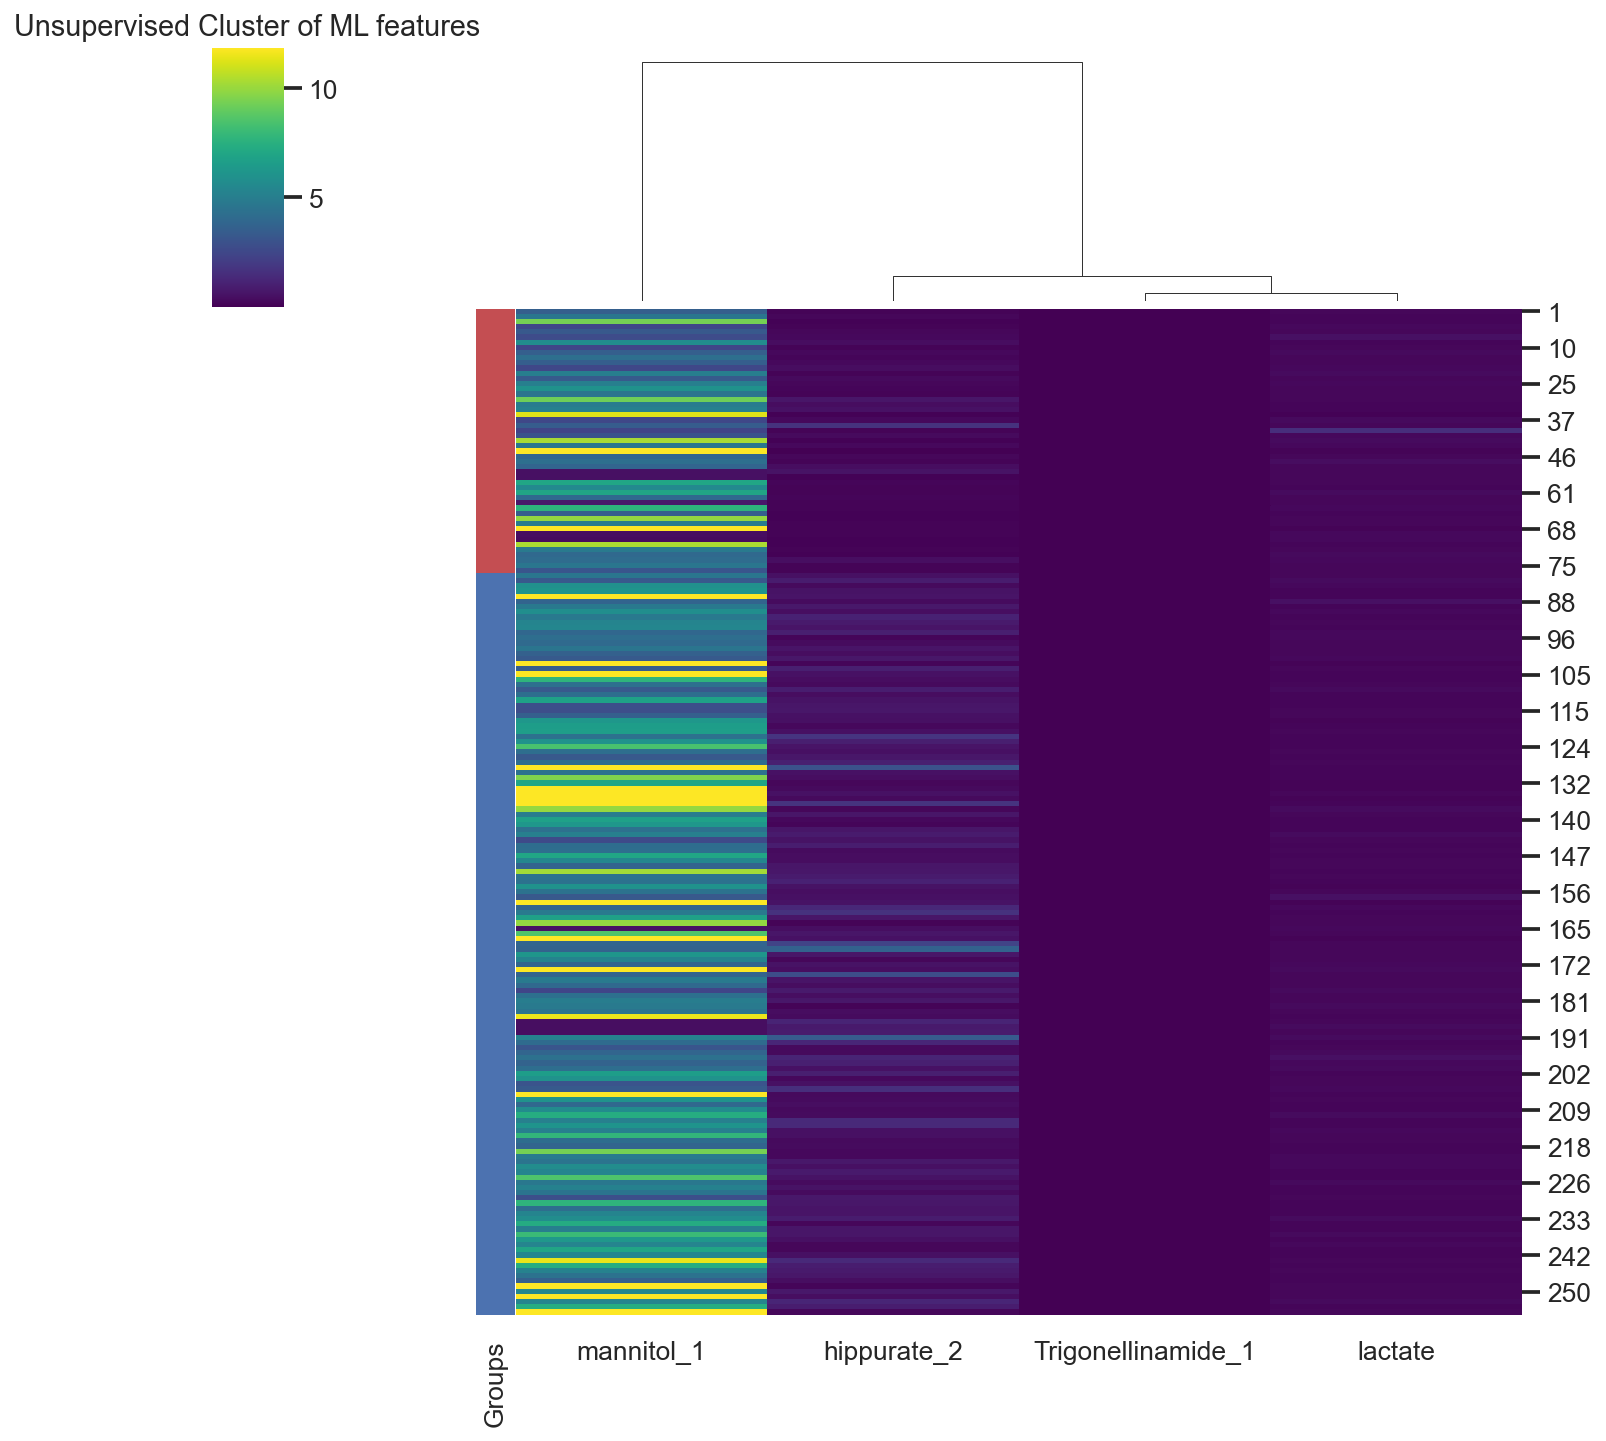

In [53]:
groups_two = biomarker2.pop('Groups')
biomarker2 = biomarker2.astype(float)
lut = dict(zip(groups_two.unique(), 'rbg'))
row_colors = groups_two.map(lut)
sns.clustermap(biomarker2, method="weighted", 
                   metric='euclidean', cmap="viridis", row_cluster=False, 
                   row_colors=row_colors, robust=True);
plt.title('Unsupervised Cluster of ML features');
# define biomarker dataframe again because of the .pop method
biomarker2 =  testcohort.iloc[:, group_loc].to_frame().join(MLfeatures2)

### [Go back to notebook content](#0)

In [54]:
#import dill                            
#filepath = 'NMR_Biomarker_Test_Cohort.pkl'
#dill.dump_session(filepath) # Save the session